# <center> Дипломный проект <br> Прогнозирование временных рядов трафика желтого такси Нью-Йорка

## <center>4 Прогнозирование большого количества рядов<br>

На прошлой неделе мы прогнозировали временной ряд со сложной сезонностью с помощью модели ARIMA на примере одной из географических зон. На этой неделе мы построим такие прогнозы для каждой зоны. Чтобы не подбирать вручную огромное количество моделей, нам понадобится сделать кластеризацию рядов.

Процесс подбора модели ARIMA в Питоне достаточно трудоёмок, поэтому мы не сможем вручную подобрать модель для каждого из рядов в выбранных ячейках. Чтобы облегчить ручной перебор, необходимо кластеризовать временные ряды и подобрать гиперпараметры модели ARIMA только один раз для всех рядов каждого кластера. 

### Загрузка модулей

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import pickle
import statsmodels.api as sm
from sklearn import linear_model
from scipy import stats
from glob import glob
import os
import itertools
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from statsmodels.tsa.stattools import acf, pacf
from scipy.cluster import hierarchy
#from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Загрузка данных

Для начала загрузим все имеющиеся данные за последние 5 месяцев:

In [4]:
def load_train_data(path_to_files,n_files):
    data_load = []
    path_files_list = sorted(glob(os.path.join(path_to_files, 'prepare_data*.csv')))
    for path_file in tqdm(path_files_list[-n_files:]):
        data_load.append(pd.read_csv(path_file, parse_dates=['time'], dtype={'region':int,'count':int}))
    return pd.concat(data_load)

In [5]:
data = load_train_data('data/Prepare_data', n_files=5)

100%|██████████| 5/5 [00:05<00:00,  1.01it/s]


Загрузим список ячеек, отобранных на 2 неделе:

In [6]:
with open('data/list_region.pkl', 'rb') as f:
    list_region = pickle.load(f)
print(f'Количество отобранных ячеек: {len(list_region)}')

Количество отобранных ячеек: 102


И отфильтруем данные только для этих ячеек:

In [7]:
data = data[data.region.apply(lambda x: x in list_region)]

Составим из отобранных данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки:

In [8]:
pickup_trips = pd.DataFrame(data.pivot_table('count',index='time',columns='region'))

Далее не будем использовать данные за последние имеющиеся месяцы — май и июнь 2016:

In [9]:
train_data = pickup_trips[:'2016-04']

In [10]:
train_data.tail()

region               1075  1076  1077  1125  1126  1127  1128  1129  1130  \
time                                                                        
2016-04-30 19:00:00   121   209   145   101   345   445   519   724   817   
2016-04-30 20:00:00   107   208    99   107   290   411   543   733   840   
2016-04-30 21:00:00    91   155   108   115   318   463   600   875   831   
2016-04-30 22:00:00   100    97    85   100   217   421   697   955   909   
2016-04-30 23:00:00    92   118    63    86   284   529   733   838   918   

region               1131  ...   1630  1684  1733  1734  1783  2068  2069  \
time                       ...                                              
2016-04-30 19:00:00   244  ...      1     0     5   152    83   140     5   
2016-04-30 20:00:00   210  ...      2     0     2   141    41   119    11   
2016-04-30 21:00:00   152  ...      2     0     2   190    67   129    16   
2016-04-30 22:00:00   203  ...      1     0     2   230    80   132    21   
2016-04-30 23:00:00   185  ...      4     0     0   195    54   134    10   

region               2118  2119  2168  
time                                   
2016-04-30 19:00:00   158    59    84  
2016-04-30 20:00:00   232    50   120  
2016-04-30 21:00:00   158    81   117  
2016-04-30 22:00:00   198    23    93  
2016-04-30 23:00:00   181    74    39  

[5 rows x 102 columns]

In [11]:
print(f'В итоге имеем данные с {min(train_data.index)} по {max(train_data.index)}')

В итоге имеем данные с 2016-02-01 00:00:00 по 2016-04-30 23:00:00


Отнормируем данные по регионам, в дальнейшем это понадобится:

In [12]:
train_data_norm = StandardScaler().fit_transform(train_data)

/home/ubuntu/miniconda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ubuntu/miniconda/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Кластеризация географических зон

На данном этапе нам необходимо подобрать число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму.

Схожесть рядов будем оценивать по средним значениям количества поездок в час по дням недели - всего по 168 значениям:

In [13]:
train_data['weekdays'] = [x.weekday() for x in train_data.index]
train_data['hours'] = [x.hour for x in train_data.index]
data_group = train_data.groupby(by=['weekdays','hours'], as_index=False,).mean()

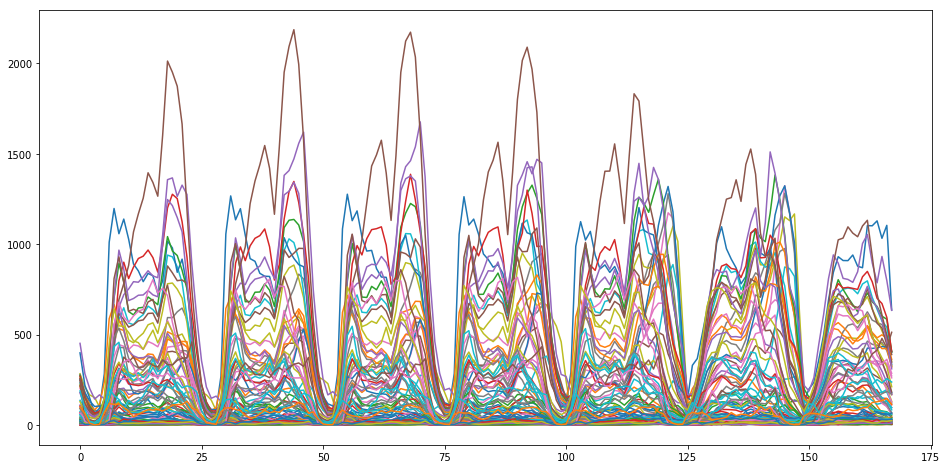

In [14]:
figure(figsize=(16,8))
plot(data_group.iloc[:,2:]);

Нам важна только форма, поэтому отнормируем полученные ряды:

In [15]:
data_group_norm = StandardScaler().fit_transform(data_group.iloc[:,2:])
features = data_group_norm.transpose()

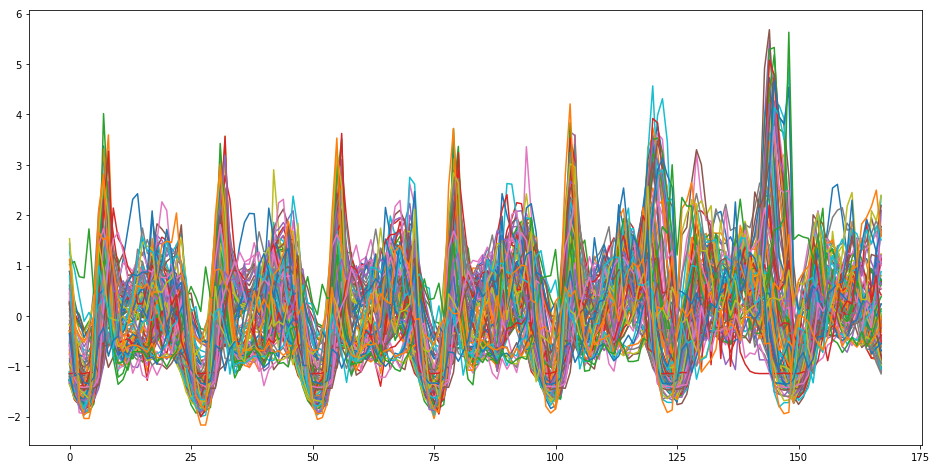

In [16]:
figure(figsize=(16,8))
plot(data_group_norm);

Посмотрим примерное количество кластеров на дендрограме: 

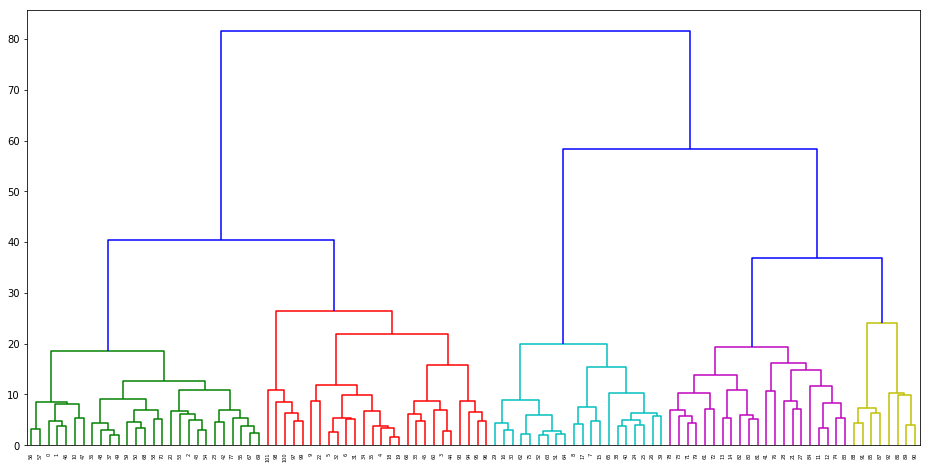

In [17]:
Z = hierarchy.linkage(features,method='ward')
figure(figsize(16,8))
dn = hierarchy.dendrogram(Z, color_threshold=30)

Хорошо выделяются 5 кластеров, если разбивать далее, то получится слишком много.

Кластеризуем с помощью KMeans и визуализируем TSNE:

In [18]:
tsne = TSNE(random_state=10)
tsne_representation = tsne.fit_transform(features)

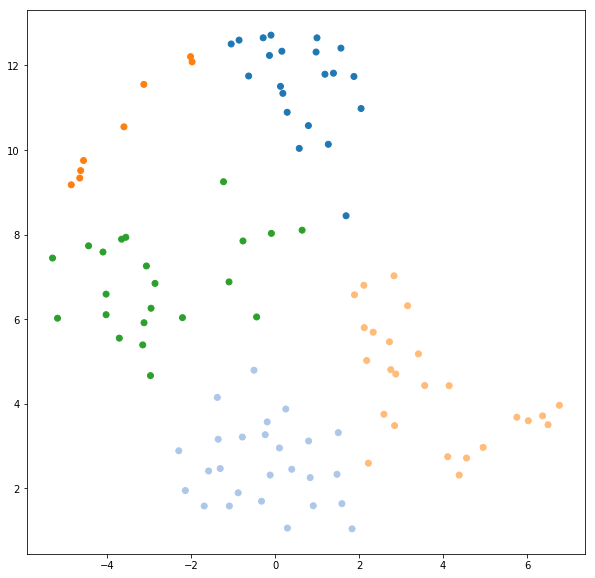

In [19]:
n_clusters = 5
model_cl = KMeans(n_clusters=n_clusters, random_state=10).fit(features)
assignments = model_cl.labels_
colors = cm.tab20(assignments)
figure(figsize=(10,10))
scatter(tsne_representation[:,0], tsne_representation[:,1], c=colors);

Получилось отличное разделение.

Посмотрим на отнормированные ряды в кластерах:

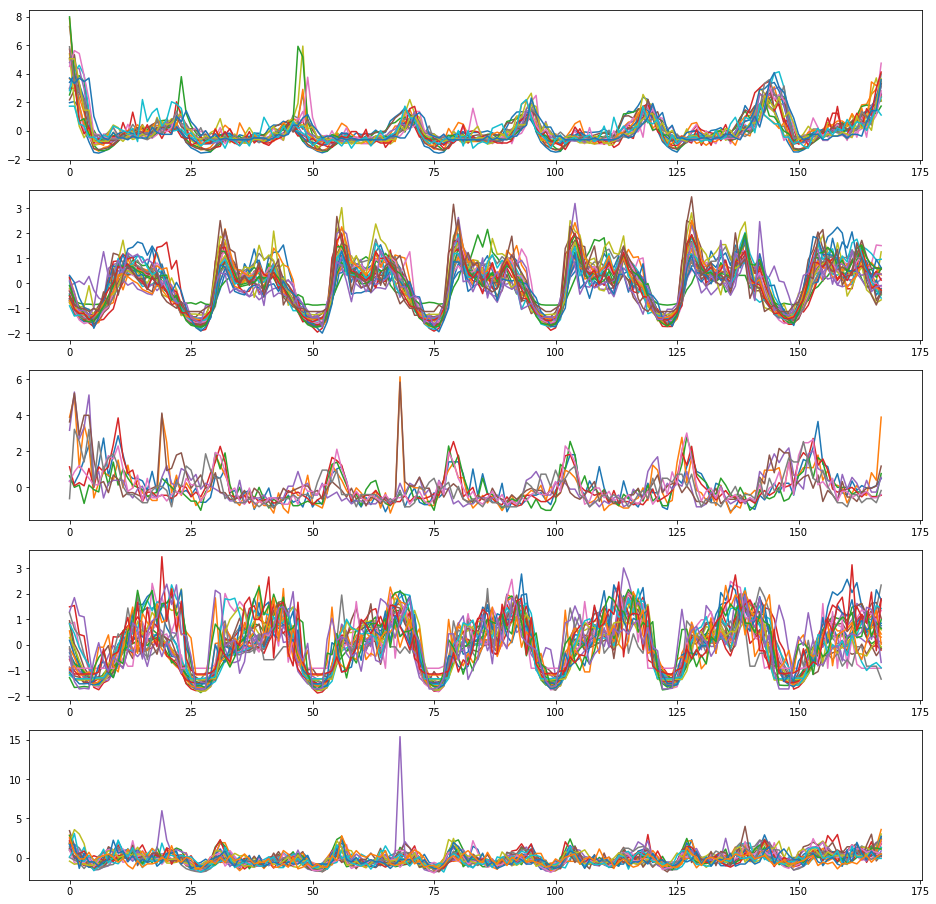

In [20]:
fig, axes = plt.subplots(nrows=n_clusters, ncols=1, figsize=(16, 16))
for i in range(n_clusters):
    axes[i].plot(train_data_norm[:,assignments == i][-168:])

### Визуализация кластеров на карте

In [ ]:
import holoviews as hv, geoviews as gv, param, paramnb, parambokeh
from geoviews.tile_sources import EsriImagery
from holoviews.streams import Selection1D
import geopandas
hv.extension('bokeh')

Загрузим сохраненную ранее сетку координат регионов:

In [ ]:
with open('data/mesh.pkl', 'rb') as f:
    mesh = pickle.load(f)

#### Интерактивная карта кластеров

In [ ]:
class NYCTaxiExplorer(hv.streams.Stream):
    n_clusters = param.Integer(default=5,bounds=(1, 10))
    
    def make_view_clusters(self, **kwargs):
        model_cl = KMeans(n_clusters=self.n_clusters).fit(features)
        assignments = model_cl.labels_
        mesh['clusters'] = assignments
        polygon = gv.Polygons(mesh,vdims=['clusters']).options(width=500, height=500, alpha=0.9,
                                                  color_index='clusters', cmap='set2')
        return polygon

In [ ]:
img = EsriImagery
explorer = NYCTaxiExplorer(name='Clustering of New-York Taxi')
parambokeh.Widgets(explorer,callback=explorer.event,width=500)
trips = hv.DynamicMap(explorer.make_view_clusters, streams=[explorer])
img * trips

В итоге мы получили 5 кластеров

### Типовые ряды кластеров

Найдем наиболее ближайшие к центру кластеров ряды:

In [22]:
dist_to_claster = [model_cl.transform(features[i:i+1,:])[0,assignments[i]] for i in range(102)]
dist = pd.DataFrame({
    #'region': list_region,
    'claster': assignments,
    'distance': dist_to_claster}, index=list_region)
list_centers = [dist[dist['claster'] == i]['distance'].idxmin() for i in range(n_clusters)]

In [23]:
print(list_centers)

[1177, 1333, 1482, 1233, 1389]


### Выбор параметров ARIMA

Как и на предыдушей неделе создадим дополнительные признаки на основе рядов Фурье и полиномов, обучим линейную регрессию и по остаткам найдем начальные параметры моделей ARIMA для каждого кластера.

P.S. Начальные параметры специально выбраны с занижением для ускорения обучения моделей. 

In [24]:
def generate_exog(index, k_week=5, k_year=2, k_pol=2):
    len_index = len(index)
    T_arr = np.arange(len(index))
    exog_sin_week = np.zeros((len_index, k_week))
    exog_cos_week = np.zeros((len_index, k_week))
    exog_sin_year = np.zeros((len_index, k_year))
    exog_cos_year = np.zeros((len_index, k_year))
    exog_polinom = np.zeros((len_index, k_pol))
    
    for i in range(k_week):
        exog_sin_week[:,i] = np.sin(T_arr * 2 * pi * (i+1) / 168)
        exog_cos_week[:,i] = np.cos(T_arr * 2 * pi * (i+1) / 168)
        
    for i in range(k_year):
        exog_sin_year[:,i] = np.sin(T_arr * 2 * pi * (i+1) / 8760)
        exog_cos_year[:,i] = np.cos(T_arr * 2 * pi * (i+1) / 8760)
        
    for i in range(k_pol):
        exog_polinom[:,i] = T_arr**(i+1)

    exog = np.concatenate((exog_sin_week, exog_cos_week,
                           exog_sin_year, exog_cos_year, 
                           exog_polinom), axis=1)
    
    return pd.DataFrame(exog, index=index)

In [25]:
train_exog = generate_exog(train_data.index)
# На графиках будем показывать только n_samples отсчетов
n_samples = 8760
param = []

#### Кластер 1

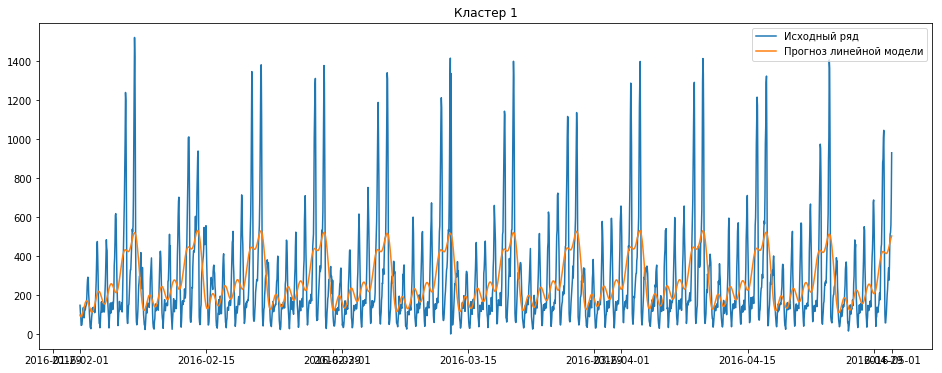

In [26]:
region = list_centers[0]
train_series = train_data.loc[:,region].resample('H').sum()
lin_model = linear_model.LinearRegression().fit(train_exog,train_series)
predict = lin_model.predict(train_exog)
plt.figure(figsize=(16,6))
plot(train_series.index[-n_samples:],train_series[-n_samples:],label='Исходный ряд')
plot(train_series.index[-n_samples:],predict[-n_samples:],label='Прогноз линейной модели')
plt.legend()
plt.title(f'Кластер 1')
plt.show()

Посмотрим на остатки

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

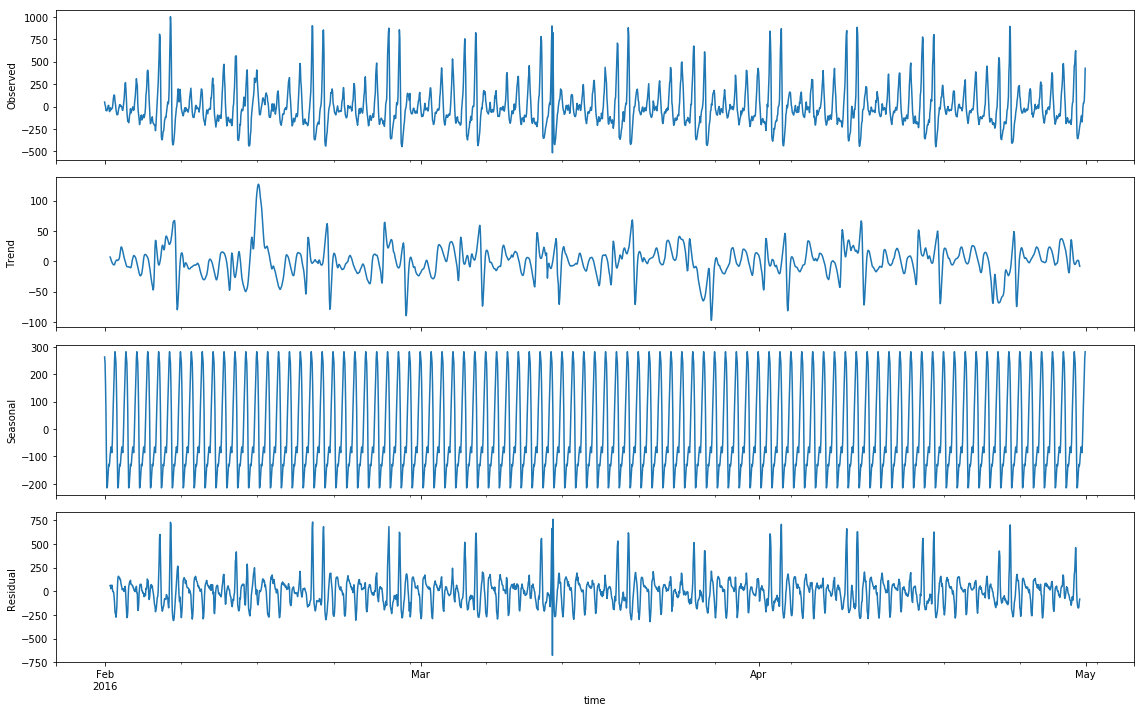

In [27]:
residual = train_series - predict
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual[-n_samples:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual)[1])
plt.show()

Тренда нет, сезонность присутствует, поэтому выполним сезонное (суточное) дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

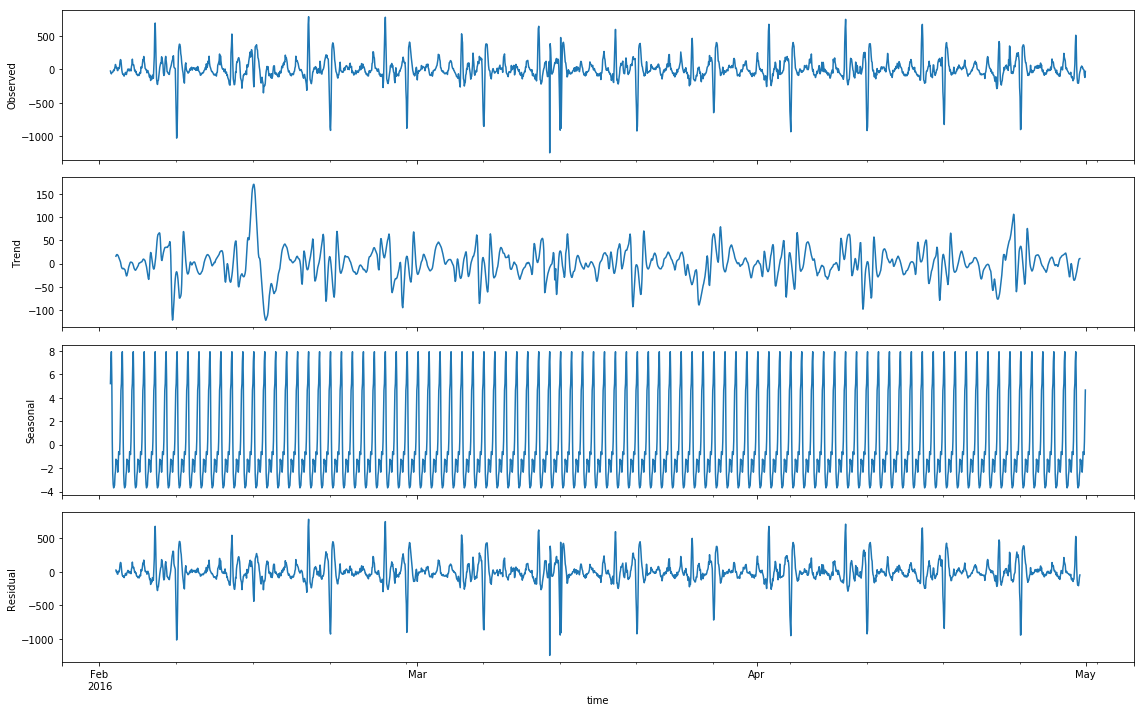

In [28]:
residual_diff = residual - residual.shift(24)
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual_diff[-n_samples:].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual_diff.dropna())[1])
plt.show()

Тренд отсутствует, и выраженная сезонность тоже.

Посмотрим на авторегрессионные функции и определим начальные приближения для ARIMA:

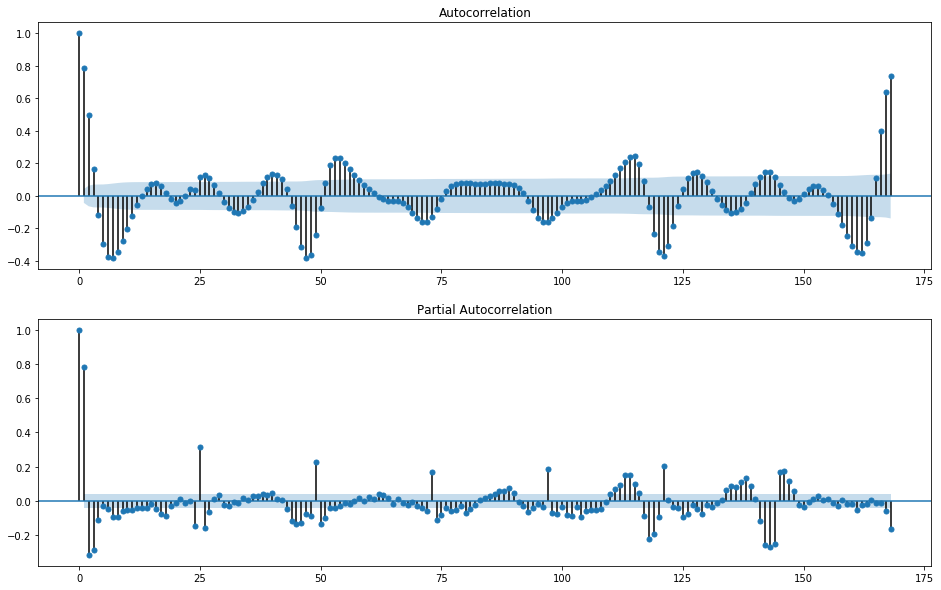

In [29]:
figure(figsize(16,10))
ax = subplot(211)
sm.graphics.tsa.plot_acf(residual_diff.dropna(), lags=168,ax=ax)
ax = subplot(212)
sm.graphics.tsa.plot_pacf(residual_diff.dropna(), lags=168,ax=ax)
plt.show()

Начальные приближения: Q=3, q=2, P=1, p=3

Добавим параметры в список в соответствии с (p,d,q,P,D,Q)

In [30]:
param.append((3,0,2,1,1,3))

#### Кластер 2

Всё тоже самое проделываем с остальными кластерами:

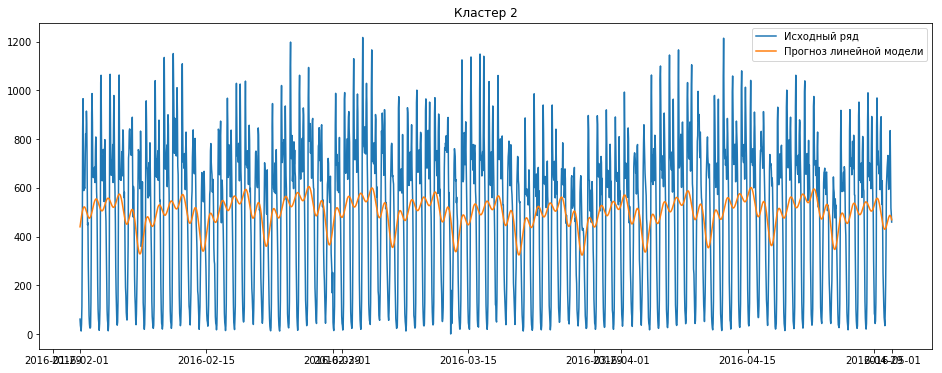

In [31]:
region = list_centers[1]
train_series = train_data.loc[:,region].resample('H').sum()
lin_model = linear_model.LinearRegression().fit(train_exog,train_series)
predict = lin_model.predict(train_exog)
plt.figure(figsize=(16,6))
plot(train_series.index[-n_samples:],train_series[-n_samples:],label='Исходный ряд')
plot(train_series.index[-n_samples:],predict[-n_samples:],label='Прогноз линейной модели')
plt.legend()
plt.title(f'Кластер 2')
plt.show()

Критерий Дики-Фуллера: p=0.000001


<Figure size 1152x720 with 0 Axes>

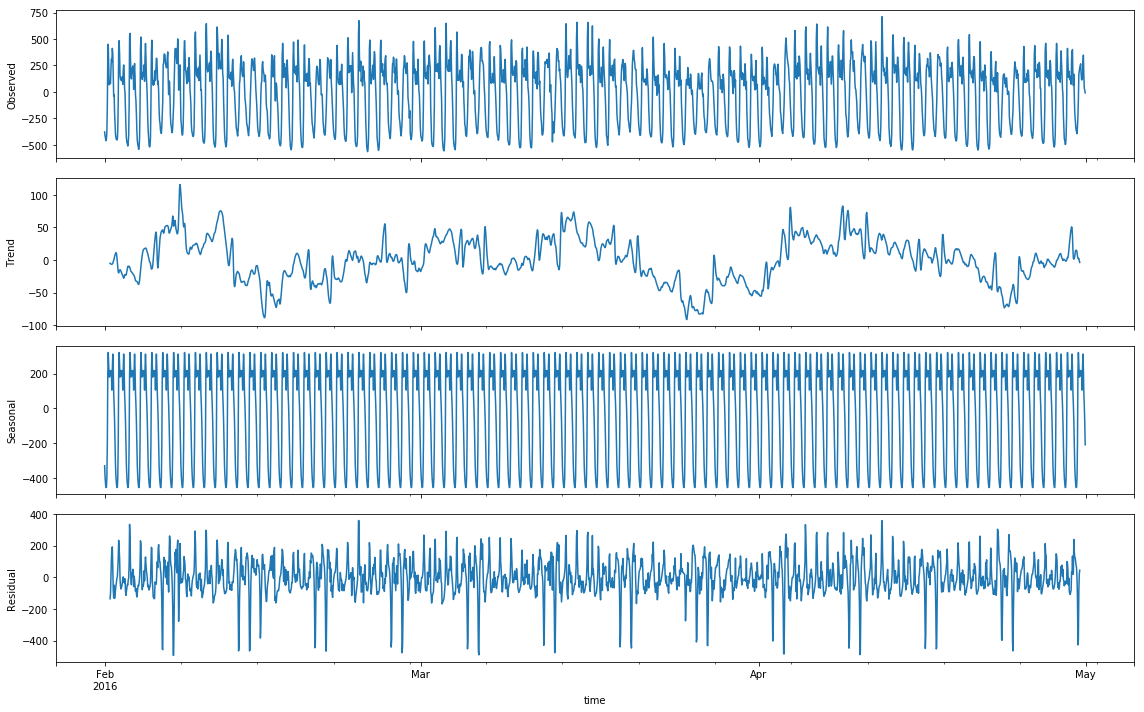

In [32]:
residual = train_series - predict
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual[-n_samples:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual)[1])
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

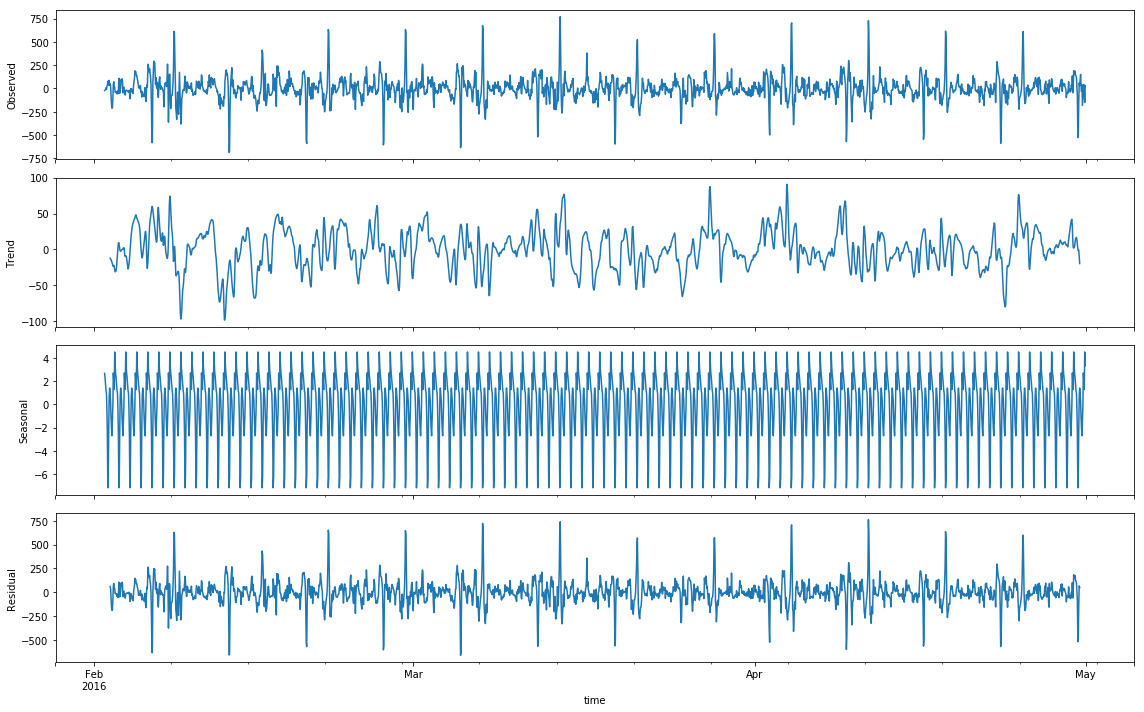

In [33]:
residual_diff = residual - residual.shift(24)
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual_diff[-n_samples:].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual_diff.dropna())[1])
plt.show()

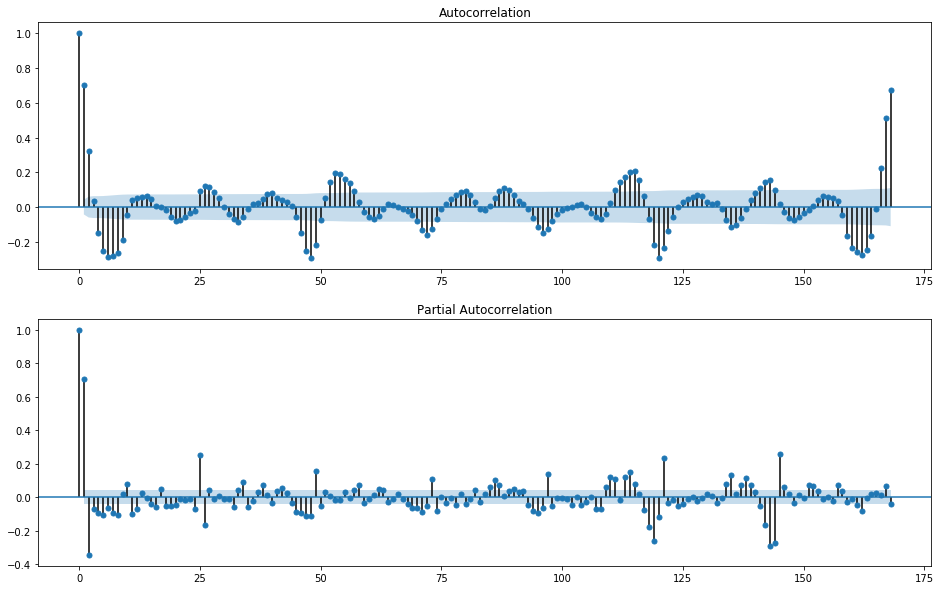

In [34]:
figure(figsize(16,10))
ax = subplot(211)
sm.graphics.tsa.plot_acf(residual_diff.dropna(), lags=168,ax=ax)
ax = subplot(212)
sm.graphics.tsa.plot_pacf(residual_diff.dropna(), lags=168,ax=ax)
plt.show()

Начальные приближения: Q=2, q=2, P=2, p=2

In [35]:
param.append((2,0,2,2,1,2))

#### Кластер 3

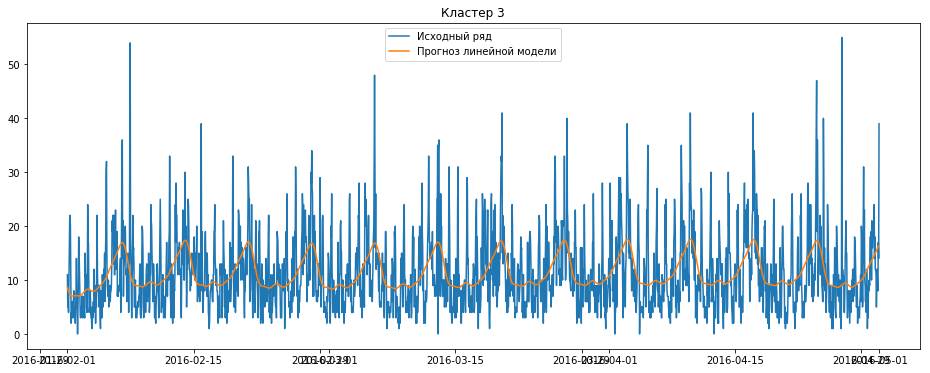

In [36]:
region = list_centers[2]
train_series = train_data.loc[:,region].resample('H').sum()
lin_model = linear_model.LinearRegression().fit(train_exog,train_series)
predict = lin_model.predict(train_exog)
plt.figure(figsize=(16,6))
plot(train_series.index[-n_samples:],train_series[-n_samples:],label='Исходный ряд')
plot(train_series.index[-n_samples:],predict[-n_samples:],label='Прогноз линейной модели')
plt.legend()
plt.title(f'Кластер 3')
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

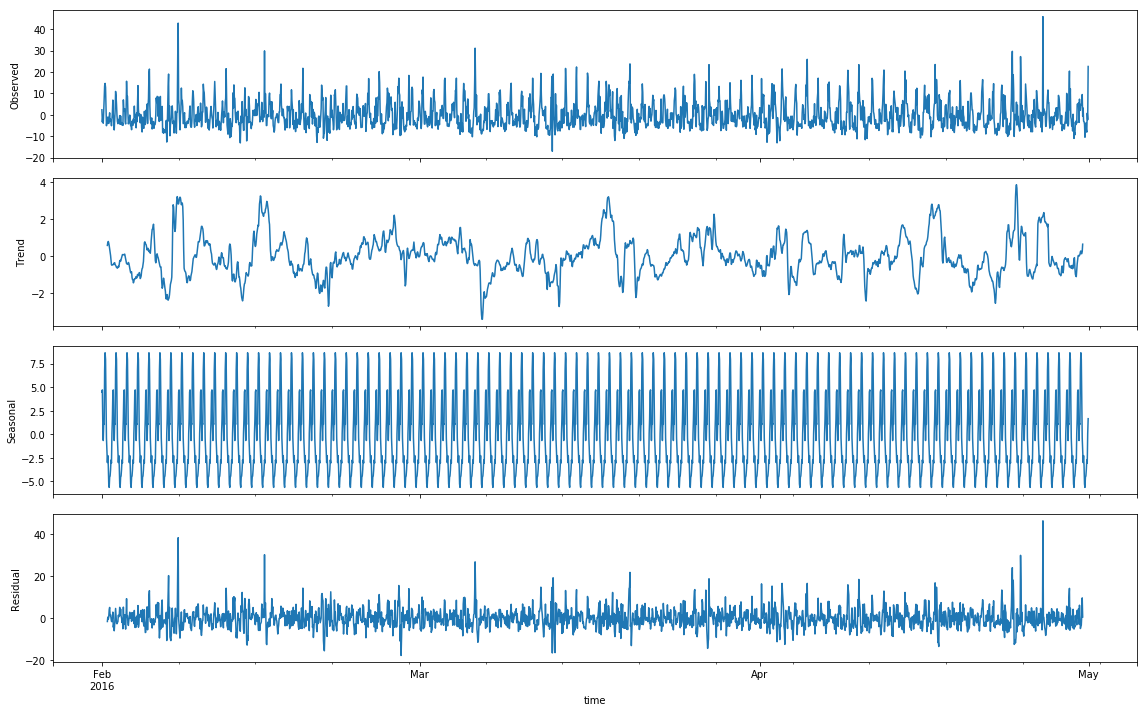

In [37]:
residual = train_series - predict
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual[-n_samples:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual)[1])
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

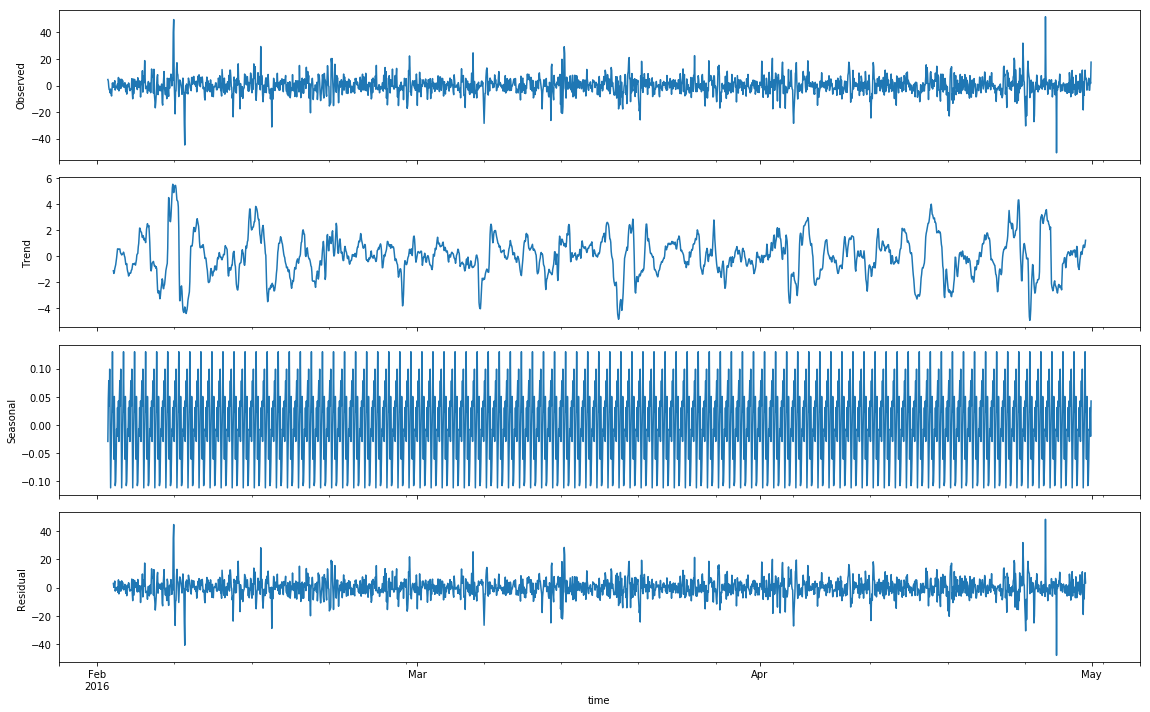

In [38]:
residual_diff = residual - residual.shift(24)
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual_diff[-n_samples:].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual_diff.dropna())[1])
plt.show()

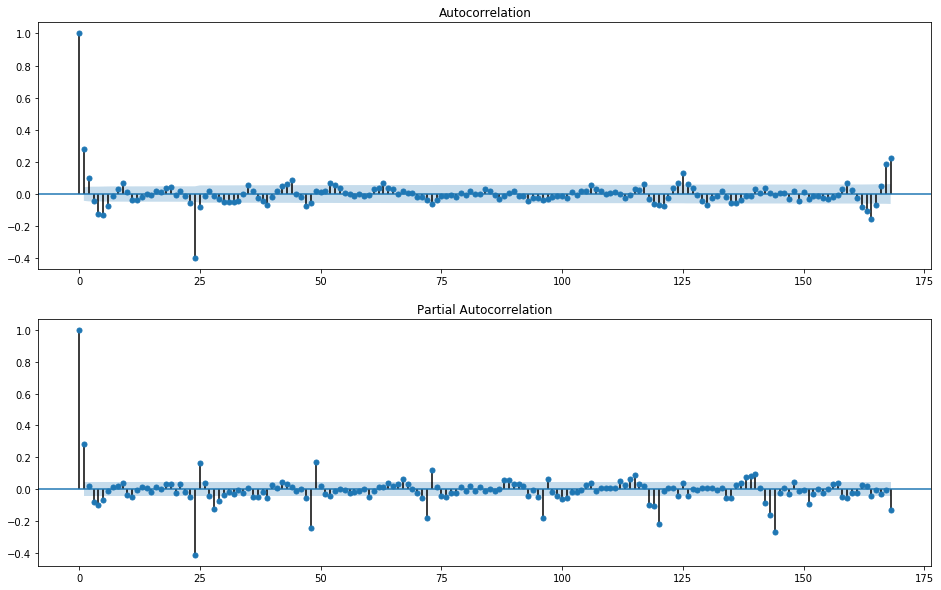

In [39]:
figure(figsize(16,10))
ax = subplot(211)
sm.graphics.tsa.plot_acf(residual_diff.dropna(), lags=168,ax=ax)
ax = subplot(212)
sm.graphics.tsa.plot_pacf(residual_diff.dropna(), lags=168,ax=ax)
plt.show()

Начальные приближения: Q=1, q=2, P=2, p=1

In [40]:
param.append((1,0,2,2,1,1))

#### Кластер 4

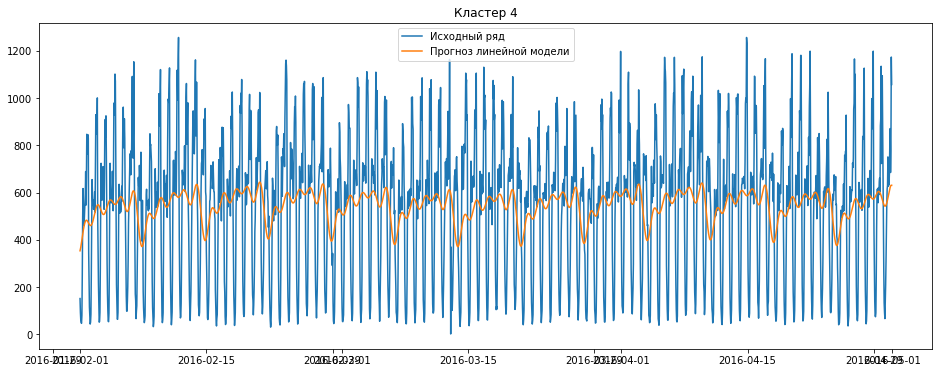

In [41]:
region = list_centers[3]
train_series = train_data.loc[:,region].resample('H').sum()
lin_model = linear_model.LinearRegression().fit(train_exog,train_series)
predict = lin_model.predict(train_exog)
plt.figure(figsize=(16,6))
plot(train_series.index[-n_samples:],train_series[-n_samples:],label='Исходный ряд')
plot(train_series.index[-n_samples:],predict[-n_samples:],label='Прогноз линейной модели')
plt.legend()
plt.title(f'Кластер 4')
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

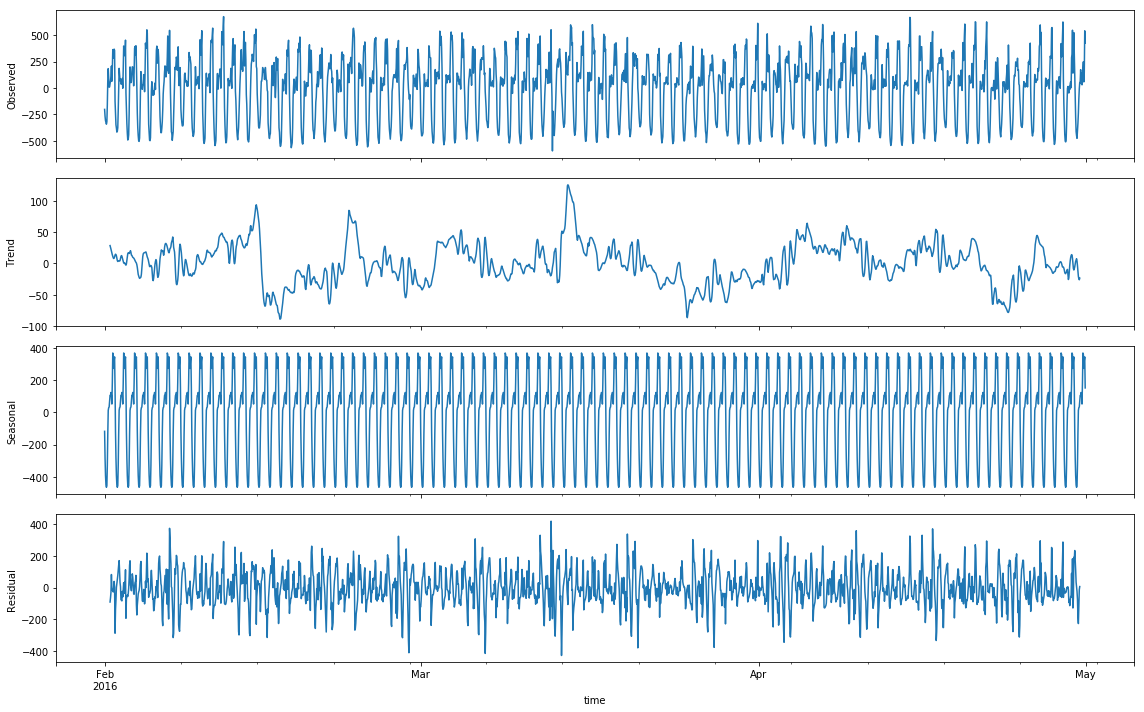

In [42]:
residual = train_series - predict
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual[-n_samples:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual)[1])
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

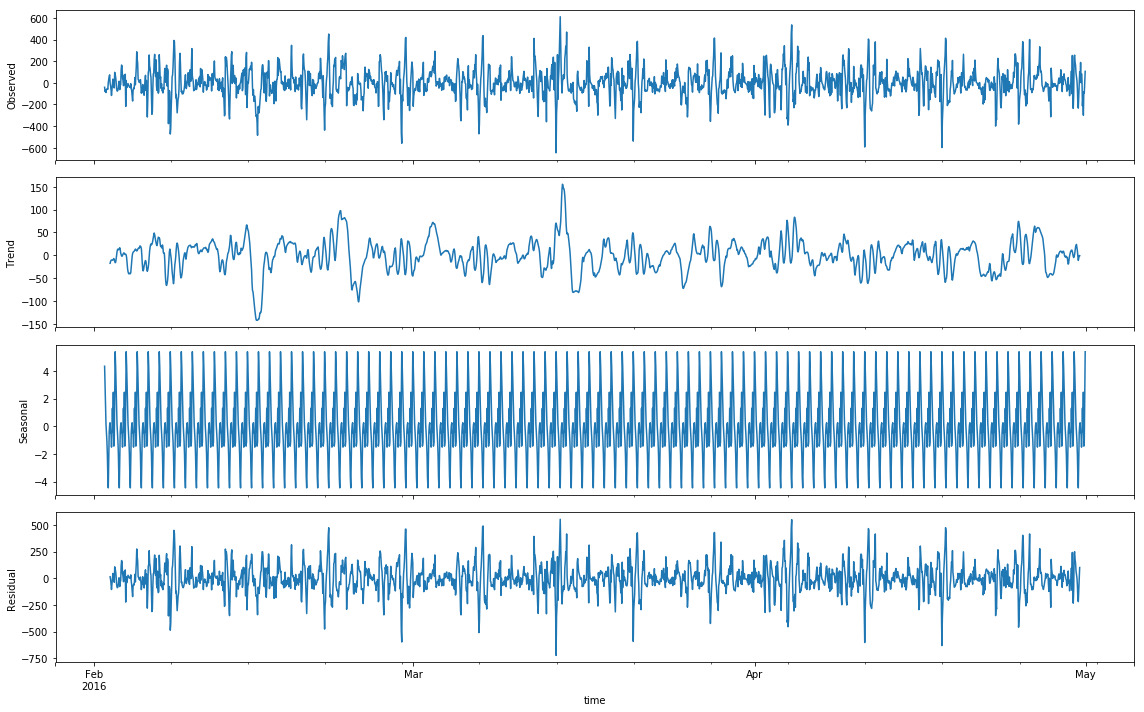

In [43]:
residual_diff = residual - residual.shift(24)
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual_diff[-n_samples:].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual_diff.dropna())[1])
plt.show()

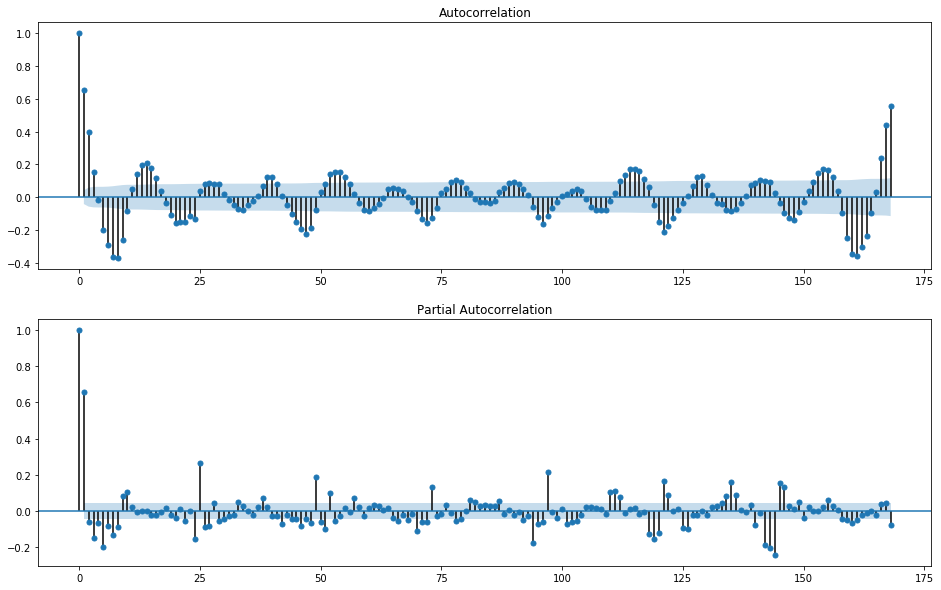

In [44]:
figure(figsize(16,10))
ax = subplot(211)
sm.graphics.tsa.plot_acf(residual_diff.dropna(), lags=168,ax=ax)
ax = subplot(212)
sm.graphics.tsa.plot_pacf(residual_diff.dropna(), lags=168,ax=ax)
plt.show()

Начальные приближения: Q=2, q=3, P=1, p=1

In [45]:
param.append((1,0,3,1,1,2))

#### Кластер 5

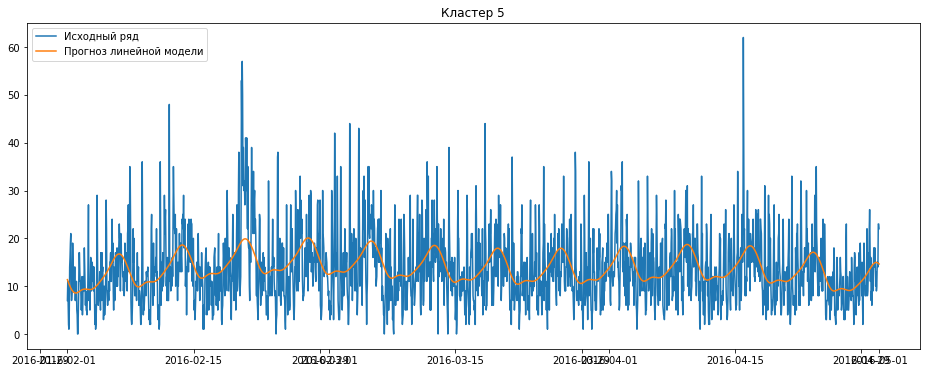

In [46]:
region = list_centers[4]
train_series = train_data.loc[:,region].resample('H').sum()
lin_model = linear_model.LinearRegression().fit(train_exog,train_series)
predict = lin_model.predict(train_exog)
plt.figure(figsize=(16,6))
plot(train_series.index[-n_samples:],train_series[-n_samples:],label='Исходный ряд')
plot(train_series.index[-n_samples:],predict[-n_samples:],label='Прогноз линейной модели')
plt.legend()
plt.title(f'Кластер 5')
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

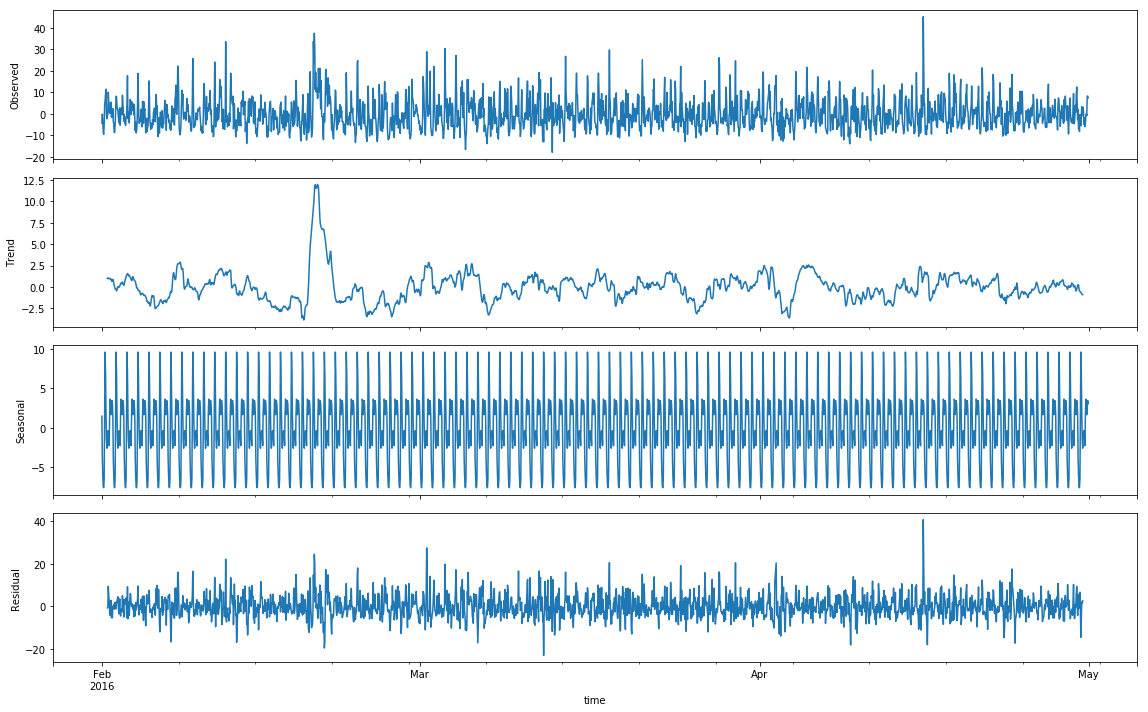

In [47]:
residual = train_series - predict
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual[-n_samples:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual)[1])
plt.show()

Критерий Дики-Фуллера: p=0.000000


<Figure size 1152x720 with 0 Axes>

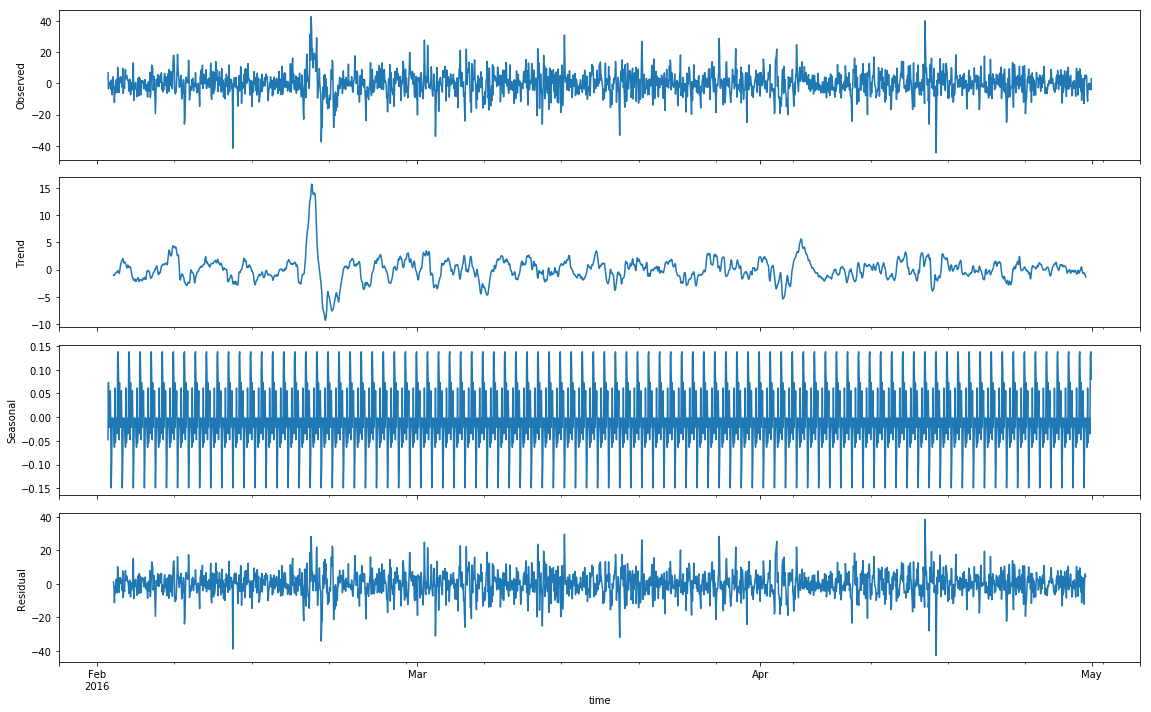

In [48]:
residual_diff = residual - residual.shift(24)
plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(residual_diff[-n_samples:].dropna()).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(residual_diff.dropna())[1])
plt.show()

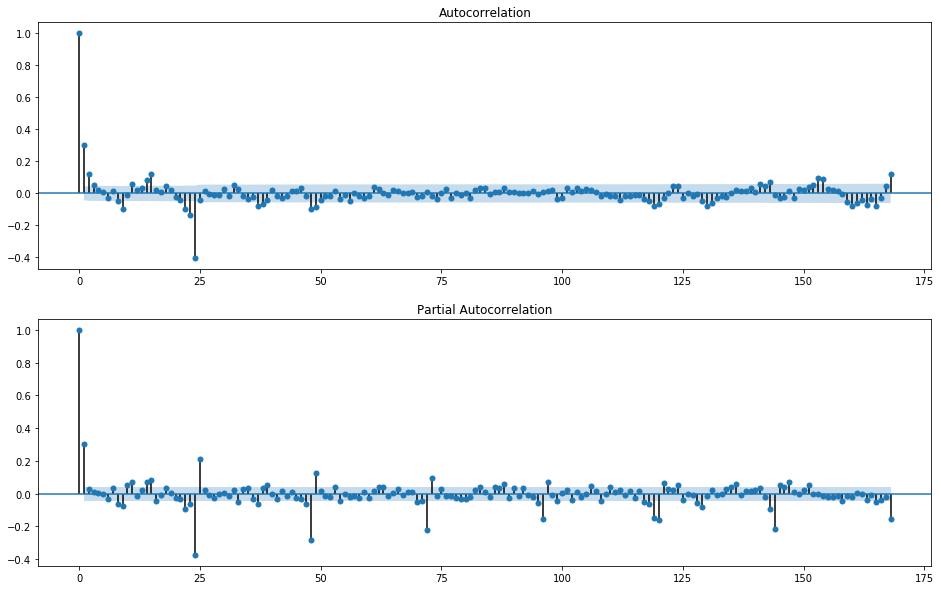

In [49]:
figure(figsize(16,10))
ax = subplot(211)
sm.graphics.tsa.plot_acf(residual_diff.dropna(), lags=168,ax=ax)
ax = subplot(212)
sm.graphics.tsa.plot_pacf(residual_diff.dropna(), lags=168,ax=ax)
plt.show()

Начальные приближения: Q=1, q=2, P=2, p=1

In [50]:
param.append((1,0,2,2,1,1))

В итоге получили список начальные приближений для 5 кластеров:

In [51]:
print(list(param))

[(3, 0, 2, 1, 1, 3), (2, 0, 2, 2, 1, 2), (1, 0, 2, 2, 1, 1), (1, 0, 3, 1, 1, 2), (1, 0, 2, 2, 1, 1)]


### Обучение ARIMA

Всё по стандартной схеме

In [58]:
def fit_arima(endog, exog, parameters_model):
    warnings.filterwarnings('ignore')
    # Список перебора параметров
    ps = range(0, parameters_model[0] + 1)
    d = parameters_model[1]
    qs = range(0, parameters_model[2] + 1)
    Ps = range(0, parameters_model[3] + 1)
    D = parameters_model[4]
    Qs = range(0, parameters_model[5] + 1)

    parameters_list = list(itertools.product(ps, qs, Ps, Qs))   
    
    # Обучение модели
    results = []
    best_aic = float("inf")
    for param in tqdm_notebook(parameters_list):
        try:
            model=sm.tsa.statespace.SARIMAX(endog, exog, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], 24),
                                            ).fit(disp=-1)
        except ValueError:
            continue
        except LinAlgError:
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
            best_param_d = (d, D)
    return (best_model, best_param, best_param_d)

### Обучение моделей

In [59]:
#models = []
for i in tqdm_notebook(range(3, n_clusters)):
    region = list_centers[i]
    endog = train_data.loc[:,region].resample('H').sum()
    exog = generate_exog(endog.index)
    models.append(fit_arima(endog, exog, param[i]))

Сохраним обученные модели в файл:

In [61]:
with open('data/models_arima.pkl', 'wb') as f:
    pickle.dump(models, f)

### Прогноз на май

In [92]:
with open('data/models_arima.pkl', 'rb') as f:
    models = pickle.load(f)

In [66]:
warnings.filterwarnings('ignore')
time_range = pd.date_range('2016.04.30 23:00', '2016.05.31 17:00', freq='H')
index = []
predicted_trips = []
trips = []
for i, region in tqdm_notebook(enumerate(list_region)):
    # Находим к какому кластеру относится ячейка
    claster = assignments[i]
    model = models[claster][0]
    param = models[claster][1]
    # Формируем данные
    endog = pickup_trips.loc[:,region].resample('H').sum()
    exog = generate_exog(endog.index)
    # Создаем новую модель на данные нужного региона
    model_fitted = sm.tsa.statespace.SARIMAX(endog, exog, order=(param[0], 0, param[1]),
                                            seasonal_order=(param[2], 1, param[3], 24)
                                            ).filter(model.params)
    # Вычисляем прогноз на 1-6 часов для каждого часа мая
    for time in tqdm_notebook(time_range):
        predict=model_fitted.predict(time, time+6, dynamic=True)
        for j in range(1,7):
            index.append((region, time, j))
            predicted_trips.append(predict[j-1])
            trips.append(endog[time+j-1])
# Сохраняем прогноз в DataFrame
index = pd.MultiIndex.from_tuples(index, names=['region', 'date', 'hour'])
predicted_data = pd.DataFrame(index=index)
predicted_data['predicted_trips'] = predicted_trips
predicted_data['trips'] = trips
predicted_data['error'] = (predicted_data['predicted_trips'] - predicted_data['trips']).abs()
Q = predicted_data['error'].sum() / 102 / 739 / 6
print(f'Средняя абсолютная ошибка на майских данный составила {Q:.2f}')

Средняя абсолютная ошибка на майских данных составила 81.01


### Прогноз на июнь для Kaggle

Теперь по такому же принципу построим прогноз на июнь для соревнования на kaggle:

In [69]:
%%time
warnings.filterwarnings('ignore')
time_range = pd.date_range('2016.05.31 23:00','2016.06.30 17:00',freq='H')
index = []
predicted_trips = []
trips = []
idx = []
for i, region in tqdm_notebook(enumerate(list_region)):
    # Находим к какому кластеру относится ячейка
    claster = assignments[i]
    model = models[claster][0]
    param = models[claster][1]
    # Формируем данные
    endog = pickup_trips.loc[:,region].resample('H').sum()
    exog = generate_exog(endog.index)
    # Создаем новую модель на данные нужного региона
    model_fitted = sm.tsa.statespace.SARIMAX(endog, exog, order=(param[0], 0, param[1]),
                                            seasonal_order=(param[2], 1, param[3], 24)
                                            ).filter(model.params)
    # Вычисляем прогноз на 1-6 часов для каждого часа мая
    for time in time_range:
        predict=model_fitted.predict(time, time+6, dynamic=True)
        for j in range(1,7):
            index.append((region, time, j))
            predicted_trips.append(predict[j-1])
            trips.append(endog[time+j-1])
            idx.append('_'.join([str(region),str(time.date()),str(time.hour),str(j)]))
# Сохраняем прогноз в DataFrame
index = pd.MultiIndex.from_tuples(index, names=['region', 'date', 'hour'])
predicted_data_to_kaggle = pd.DataFrame(index=index)
predicted_data_to_kaggle['id'] = idx
predicted_data_to_kaggle['y'] = predicted_trips
predicted_data_to_kaggle.to_csv('submissions/submission_1.csv', index=False)
with open('data/predict_arima.pkl', 'wb') as f:
    pickle.dump(predicted_data_to_kaggle, f)
print('OK')

OK


Получилось очень плохое качество, посмотрим на график прогноза:

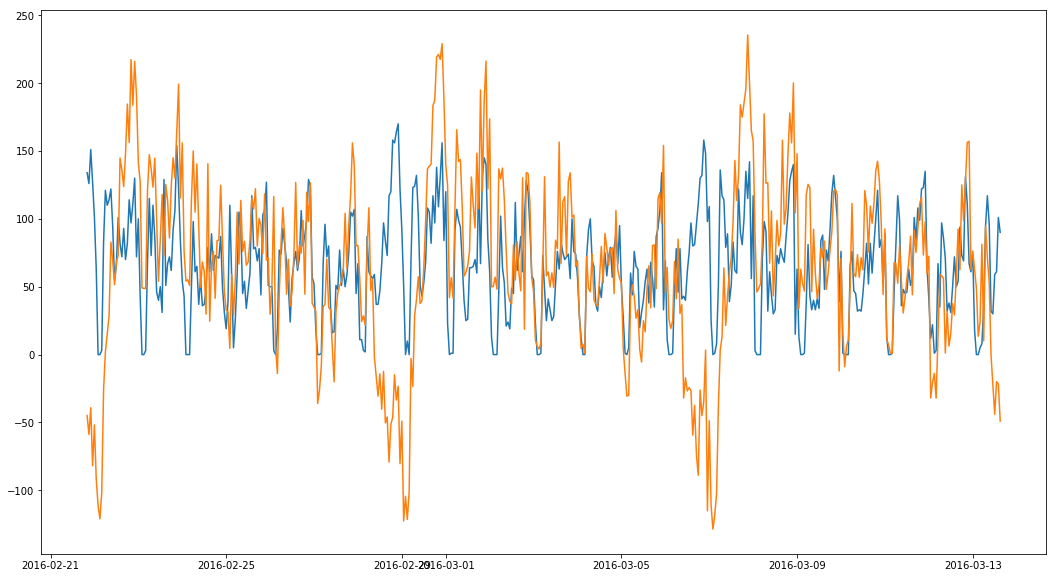

In [81]:
figure(figsize=(18,10))
plot(endog.index[500:1000], endog[500:1000])
plot(endog.index[500:1000], model_fitted.fittedvalues[500:1000])
show()

Полученный результат не впечатляет. Возможно использована слишком маленькая выборка для обучения, но брать больше смысла не имеет - обучение будет длиться сутками, поэтому в дальнейшем попробуем другие модели.

Ссылка https://www.kaggle.com/submissions/7963879/7963879.zip